### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import astropy.units as u

from scipy.interpolate import interp1d

from sklearn.neighbors import KernelDensity

import os
import glob

/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/elismar/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=2.725)

In [3]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 35 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

[ 1.21154796e-05  4.39319909e-04 -2.11420409e-02  1.77834331e-01]


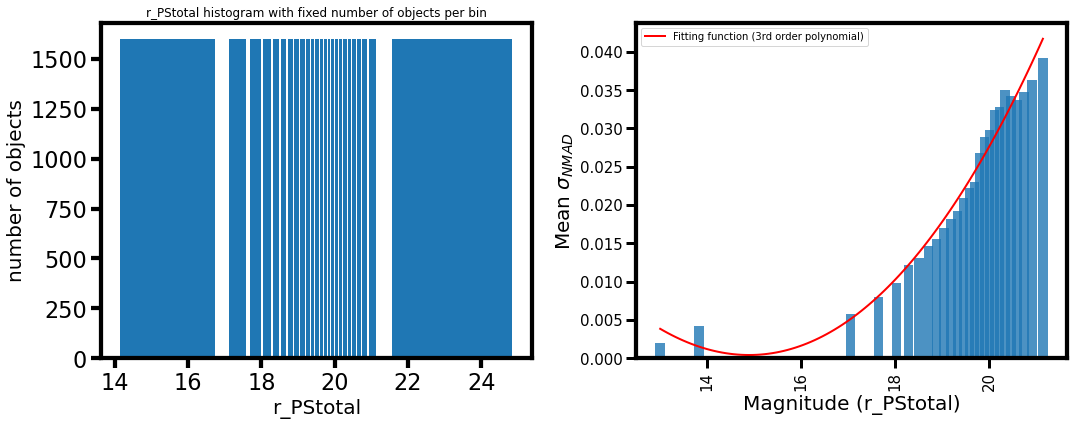

In [4]:
from galaxy_cluster_membership import *

### Define cluster data

In [5]:
#Information based on the table of the paper draft (https://www.overleaf.com/4958173787sbwbtsgjzbch#c79586)

cl_names = np.array(["A168", "MKW4"])

#New values
cl_ra = np.array([18.740487, 180.990540])
cl_dec = np.array([0.437564, 1.888290])
cl_z = np.array([0.044596, 0.020000])
cl_radii_kpc = np.array([0.989478, 1.040702])*1000 #kpc

#Old values
# cl_ra = np.array([18.740487, 180.988406])
# cl_dec = np.array([0.437564, 1.888278])
# cl_z = np.array([0.044596, 0.0205])
# cl_radii_kpc = np.array([0.869956, 0.882308])*1000 #kpc


In [6]:
cl_radii_deg = []
for zi, i in zip(cl_z, range(len(cl_z))):
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=zi).value/60.
    radius_deg = cl_radii_kpc[i] / (kpc_scale * 3600) #Convert radius from kpc to deg
    cl_radii_deg.append(radius_deg)
    
cl_radii_deg = np.asarray(cl_radii_deg)

In [54]:
cluster = 0

radius_cluster = cl_radii_deg[cluster]
z_cluster = cl_z[cluster]
ra0 = cl_ra[cluster]
dec0 = cl_dec[cluster]

if cluster == 0:
    #optical center of A168. It works better to make the radial fit
    ra0 = 18.8129
    dec0 = 0.2657

### Legacy

In [16]:
table_path_a168_legacy = "tables/A168/A168-05012025.parquet"
table_path_mkw4_legacy = "tables/MKW4/MKW4-05012025.parquet"

In [17]:
table_a168_legacy = pd.read_parquet(table_path_a168_legacy)
table_mkw4_legacy = pd.read_parquet(table_path_mkw4_legacy)

In [18]:
table_mkw4_legacy.to_csv("tables/MKW4/MKW4-05012025.csv", index=False)
table_a168_legacy.to_csv("tables/A168/A168-05012025.csv", index=False)

In [8]:
table_a168_legacy = pd.read_csv("tables/A168_legacy.csv", usecols=["ra", "dec", "type", "mag_r"])
table_mkw4_legacy = pd.read_csv("tables/mkw4_legacy.csv", usecols=["ra", "dec", "type", "mag_r"])

In [9]:
ra_a168_legacy = table_a168_legacy["ra"]
dec_a168_legacy = table_a168_legacy["dec"]
type_a168_legacy = table_a168_legacy["type"]
mag_r_a168_legacy = table_a168_legacy["mag_r"]

ra_mkw4_legacy = table_mkw4_legacy["ra"]
dec_mkw4_legacy = table_mkw4_legacy["dec"]
type_mkw4_legacy = table_mkw4_legacy["type"]
mag_r_mkw4_legacy = table_mkw4_legacy["mag_r"]

In [10]:
mask_galaxies_a168 = (type_a168_legacy != "PSF") & (type_a168_legacy != "DUP")
mask_galaxies_mkw4 = (type_mkw4_legacy != "PSF") & (type_mkw4_legacy != "DUP")

/tmp/ipykernel_283836/48623749.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(pad=3.0)
/home/elismar/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


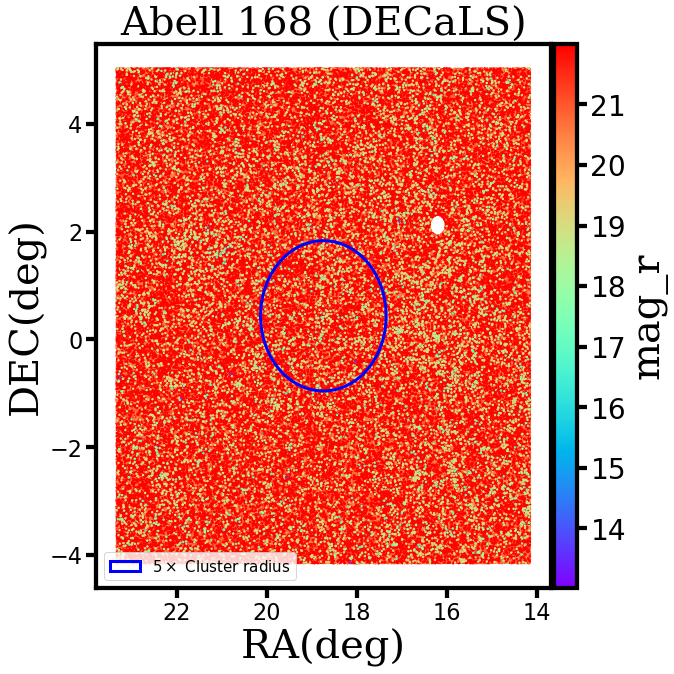

In [11]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_a168_legacy[mask_galaxies_a168], dec_a168_legacy[mask_galaxies_a168], 
            marker='o', c=mag_r_a168_legacy[mask_galaxies_a168], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("Abell 168 (DECaLS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="mag_r", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

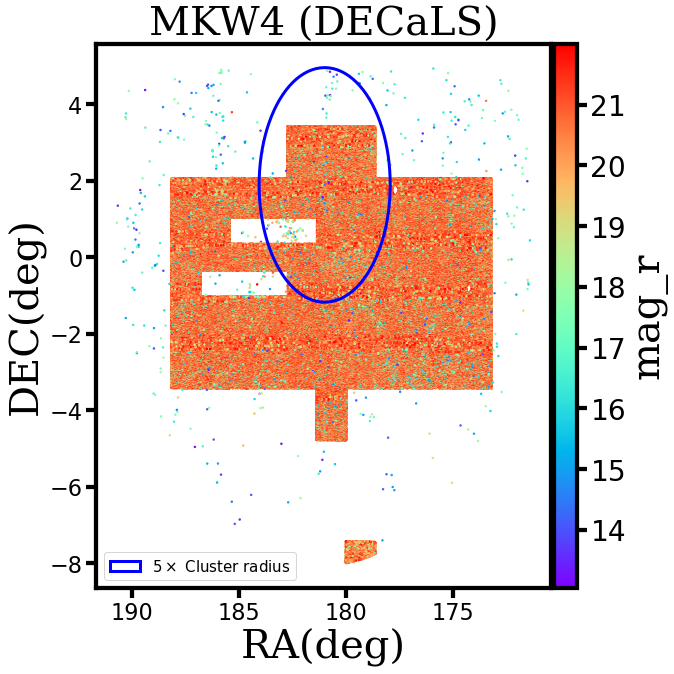

In [14]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_mkw4_legacy[mask_galaxies_mkw4], dec_mkw4_legacy[mask_galaxies_mkw4], 
            marker='o', c=mag_r_mkw4_legacy[mask_galaxies_mkw4], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("MKW4 (DECaLS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="mag_r", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

### S-PLUS

In [109]:
table_path_a168_splus = "tables/a168/A168_splus_rPStotal.csv"

table_path_mkw4_splus = "tables/mkw4/mkw4_splus_rPStotal.csv"

In [110]:
table_a168_splus = pd.read_csv(table_path_a168_splus, usecols=["ID", "RA", "DEC", "zml", "r_PStotal", "remove_flag"])

table_mkw4_splus = pd.read_csv(table_path_mkw4_splus, usecols=["ID", "RA", "DEC", "zml", "r_PStotal", "remove_flag"])

In [111]:
table_mkw4_splus["ID"].str[7:-8].unique()

array(['SPLUS-n02n21', 'SPLUS-n01s23', 'SPLUS-n02n23', 'SPLUS-n01s22',
       'SPLUS-n01s25', 'SPLUS-n01s21', 'SPLUS-n02n25', 'SPLUS-n01s24',
       'SPLUS-n02n22', 'SPLUS-n02s23', 'SPLUS-n02s24', 'SPLUS-n02s22',
       'SPLUS-n02n24'], dtype=object)

In [115]:
np.array(pd.read_csv("/home/elismar/Downloads/splus_fields_5r200.csv")["field"])

array(['SPLUS-n01s21_predicted', 'SPLUS-n01s22_predicted',
       'SPLUS-n01s23_predicted', 'SPLUS-n01s24_predicted',
       'SPLUS-n01s25_predicted', 'SPLUS-n01s26_predicted',
       'SPLUS-n02n21_predicted', 'SPLUS-n02n22_predicted',
       'SPLUS-n02n23_predicted', 'SPLUS-n02n24_predicted',
       'SPLUS-n02n25_predicted', 'SPLUS-n02n26_predicted',
       'SPLUS-n02s21_predicted', 'SPLUS-n02s22_predicted',
       'SPLUS-n02s23_predicted', 'SPLUS-n02s24_predicted',
       'SPLUS-n02s25_predicted', 'SPLUS-n03n22_predicted',
       'SPLUS-n03n23_predicted', 'SPLUS-n03n24_predicted'], dtype=object)

In [17]:
ra_a168_splus = table_a168_splus["RA"]
dec_a168_splus = table_a168_splus["DEC"]
zml_a168_splus = table_a168_splus["zml"]
rpstotal_a168_splus = table_a168_splus["r_PStotal"]
remove_flag_a168_splus = table_a168_splus["remove_flag"]

ra_mkw4_splus = table_mkw4_splus["RA"]
dec_mkw4_splus = table_mkw4_splus["DEC"]
zml_mkw4_splus = table_mkw4_splus["zml"]
rpstotal_mkw4_splus = table_mkw4_splus["r_PStotal"]
remove_flag_mkw4_splus = table_mkw4_splus["remove_flag"]

In [18]:
mask_splus_a168 = (remove_flag_a168_splus == False) & (rpstotal_a168_splus < 90)

mask_splus_mkw4 = (remove_flag_mkw4_splus == False) & (rpstotal_mkw4_splus < 90)

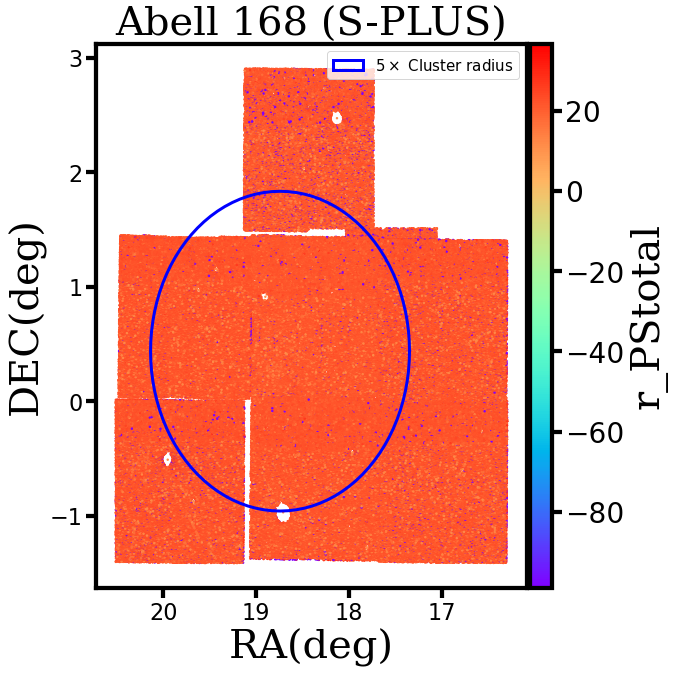

In [23]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_a168_splus[mask_splus_a168], dec_a168_splus[mask_splus_a168], 
            marker='o', c=rpstotal_a168_splus[mask_splus_a168], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("Abell 168 (S-PLUS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="r_PStotal", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

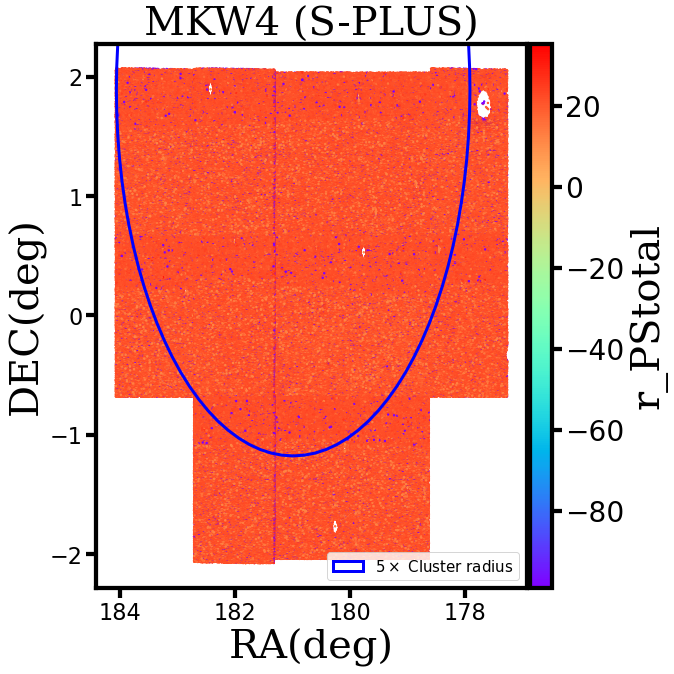

In [21]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_mkw4_splus[mask_splus_mkw4], dec_mkw4_splus[mask_splus_mkw4], 
            marker='o', c=rpstotal_mkw4_splus[mask_splus_mkw4], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("MKW4 (S-PLUS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="r_PStotal", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

I crossmatched S-PLUS and Legacy tables on TOPCAT, using 2 arcsecs for the crossmatch radius. Table names:

 - "a168_legacy_splus_rPStotal_crossmatch.csv"
 - "mkw4_legacy_splus_rPStotal_crossmatch.csv"
 
 We also have to do a crossmatch with the Spectroscopic_Catalogue (I used 2 arcsecs as well). Resulting table names:
 
 - "a168_legacy_splus_rPStotal_specz_crossmatch.csv"
 - "mkw4_legacy_splus_rPStotal_specz_crossmatch.csv"

### Concatenating tables from Erik

In [106]:
#Concatenate the data from the clusters that Erik sent
#There are tables that end with "_predicted" and others that don't. The second are the ones that contain information about the borders (I imagine this means that they have the flag to remove
#duplicated objects in the borders of S-PLUS)

fields_dir = "tables/a168/"
os.chdir(fields_dir)
cwd = os.getcwd()
fields = os.listdir(cwd)

os.chdir("../../")
os.getcwd()

'/work/Doc/galaxy-cluster-membership'

In [107]:
csv_files = np.array(glob.glob(fields_dir + "*.csv")).tolist()
df_list = (pd.read_csv(file) for file in csv_files)
big_df = pd.concat(df_list, ignore_index=True)

In [108]:
big_df.to_csv("tables/a168_additional_columns.csv", index=False)

In [ ]:
mask_fields = np.isin(glob.glob(fields_dir + "*.csv") , glob.glob(fields_dir + "*_predicted.csv"))

csv_files_predicted = glob.glob(fields_dir + "*_predicted.csv") 
df_list_predicted = (pd.read_csv(file) for file in csv_files_predicted)
big_df_predicted = pd.concat(df_list_predicted, ignore_index=True)

csv_files = np.array(glob.glob(fields_dir + "*.csv"))[~mask_fields].tolist()
df_list = (pd.read_csv(file) for file in csv_files)
big_df = pd.concat(df_list, ignore_index=True)

In [ ]:
big_df_predicted.to_csv("tables/mkw4_predicted.csv", index=False)
big_df.to_csv("tables/mkw4.csv", index=False)

### Loading tables

In [55]:
#r_auto é a magnitude padrão pra reportar as métricas dos photo-zs segundo o Erik
col_names = ['ra', 'dec', 'zml', 'pdf_weights_0', 'pdf_weights_1', 'pdf_weights_2', 'pdf_means_0',
       'pdf_means_1', 'pdf_means_2', 'pdf_stds_0', 'pdf_stds_1', 'pdf_stds_2', 'r_auto', 'odds', 'z', 'flag_member']

In [56]:
if cl_names[cluster] == "A168":
#     t = pd.read_csv("tables/a168/a168_legacy_splus_rPStotal_crossmatch.csv", usecols=col_names)
#     t_specz = pd.read_csv("tables/a168/a168_legacy_splus_rPStotal_speczs00012_crossmatch.csv")
#     t = pd.read_csv("tables/a168/a168_cleaned.csv")
    t = pd.read_csv("tables/A168/A168-05012025.csv")
    
if cl_names[cluster] == "MKW4":
#     t = pd.read_csv("tables/mkw4/mkw4_legacy_splus_rPStotal_crossmatch.csv")
#     t_specz = pd.read_csv("tables/mkw4/mkw4_legacy_splus_rPStotal_speczs00027_crossmatch.csv")
#     t = pd.read_csv("tables/MKW4/mkw4_cleaned.csv")
    t = pd.read_csv("tables/MKW4/MKW4-05012025.csv")
    

print("Loading data for cluster {}".format(cl_names[cluster]))
print("Cluster redshift: {:.4f}".format(z_cluster))
print("Cluster radius: {:.2f} Kpc".format(cl_radii_kpc[cluster]))
    
    
rauto = np.asarray(t["r_auto"])
t = t[~np.isnan(rauto)]

rauto = np.asarray(t["r_auto"])
ra = np.asarray(t["ra"])
dec = np.asarray(t["dec"])
zml = np.asarray(t["zml"])
pdf_weights = np.array([t[col_name] for col_name in ["pdf_weights_" + str(i) for i in range(0, 3)]])
pdf_means = np.array([t[col_name] for col_name in ["pdf_means_" + str(i) for i in range(0, 3)]])
pdf_stds = np.array([t[col_name] for col_name in ["pdf_stds_" + str(i) for i in range(0, 3)]])
z = np.asarray(t["z"])
flag_member = np.asarray(t["flag_member"])


ra_specz_members = ra[flag_member == 0]
dec_specz_members = dec[flag_member == 0]
z_specz_members = z[flag_member == 0]
zml_specz_members = zml[flag_member == 0]


# objid_specz = np.asarray(t_specz["ID"])
# ra_specz = np.asarray(t_specz["RA_1"])
# dec_specz = np.asarray(t_specz["DEC_1"])
# zml_specz = np.asarray(t_specz["zml"])
# pdf_weights_specz = np.array([t_specz[col_name] for col_name in ["pdf_weights_" + str(i) for i in range(0, 3)]])
# pdf_means_specz = np.array([t_specz[col_name] for col_name in ["pdf_means_" + str(i) for i in range(0, 3)]])
# pdf_stds_specz = np.array([t_specz[col_name] for col_name in ["pdf_stds_" + str(i) for i in range(0, 3)]])
# rpstotal_specz = np.asarray(t_specz["r_PStotal"])
# z = np.asarray(t_specz["z"])

Loading data for cluster A168
Cluster redshift: 0.0446
Cluster radius: 989.48 Kpc


## Perform the membership

### Inspecting the clusters (spectroscopic)
Eu costumava fazer esses plots com os membros espectroscópicos quando eu usava a tabela do Paulo. Mas agora estou usando a tabela do Natanael, que coloca os membros espectroscópicos junto com os fotométricos tudo numa mesma tabela, então se eu quiser continuar fazendo esses plots teria que mudar algumas coisas aqui no código

In [57]:
#Não tem porque impor uma limitação em raio ou em redshift nos membros espectroscópicos. 
#Podemos plotar todos os membros espectroscópicos sem restrição
dist_specz_members = clustercentric_distance(ra_specz_members, dec_specz_members, ra0, dec0)

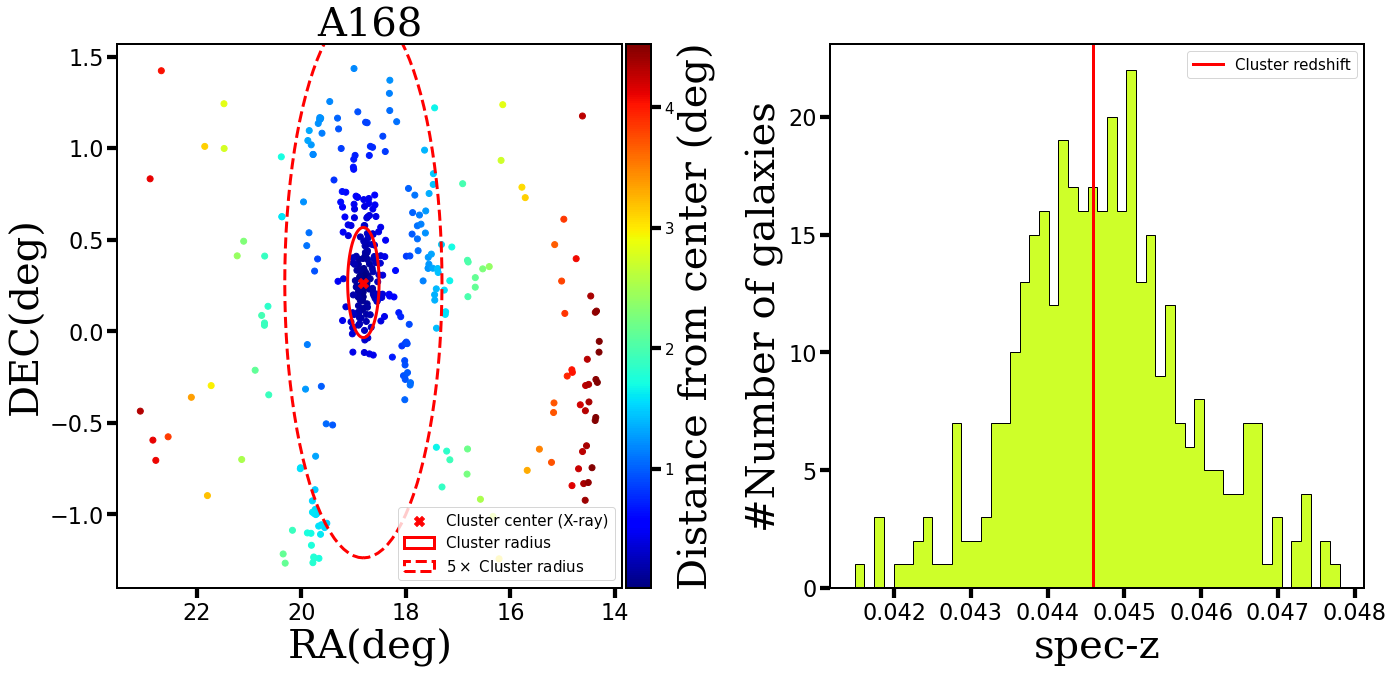

In [58]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)

sc1 = ax1.scatter(ra_specz_members, dec_specz_members, marker='o', c=dist_specz_members, cmap=cm.jet, rasterized=True)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center (X-ray)")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r)
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)

ax1.legend(fontsize=labelsize)


ax2 = fig.add_subplot(122)
ax2.hist(z_specz_members, bins=50, color=colors1[5], histtype='stepfilled', edgecolor='k')
ax2.set_xlabel('spec-z',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(z_cluster, color="red", lw=3, label="Cluster redshift")

ax2.legend(fontsize=labelsize)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-real-clusters/RA_DEC_z_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

### Inspecting the clusters (photometric)

In [59]:
dist = clustercentric_distance(ra, dec, ra0, dec0)

In [60]:
sigma_z = np.array([sigma_nmad_(r) for r in rauto])

#Define the volume of the cluster
#fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
fz1 = 3.0
fz2 = fz1
fr = 5.0

#This mask defines all galaxies in the fr*R200 projected area of the cluster and also imposes a magnitude limit to the galaxies
mask_cluster_region = (dist < fr*radius_cluster) & (rauto < 21)

#This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
mask_cluster = mask_cluster_region & (zml > z_cluster - fz1*sigma_z*(1+z_cluster)) & (zml < z_cluster + fz1*sigma_z*(1+z_cluster))

In [61]:
#Photo-z bias computed by me
z_bins = 50
bw = (zml[mask_cluster].max() - zml[mask_cluster].min()) / z_bins

kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(zml[mask_cluster][:, np.newaxis])
zz_phot = np.linspace(zml[mask_cluster].min(), zml[mask_cluster].max(), len(zml[mask_cluster]))[:, np.newaxis]
log_dens_zz_phot = kde.score_samples(zz_phot)

zp_peak = zz_phot[np.argmax(np.exp(log_dens_zz_phot))]
zp_bias = zp_peak - z_cluster

zml_unbiased = zml - zp_bias

mask_cluster_unbiased = mask_cluster_region & (zml_unbiased > z_cluster - 
                    fz1*sigma_z*(1+z_cluster)) & (zml_unbiased < z_cluster + fz1*sigma_z*(1+z_cluster))

print("zp_bias = {}".format(zp_bias))

zp_bias = [0.00489033]


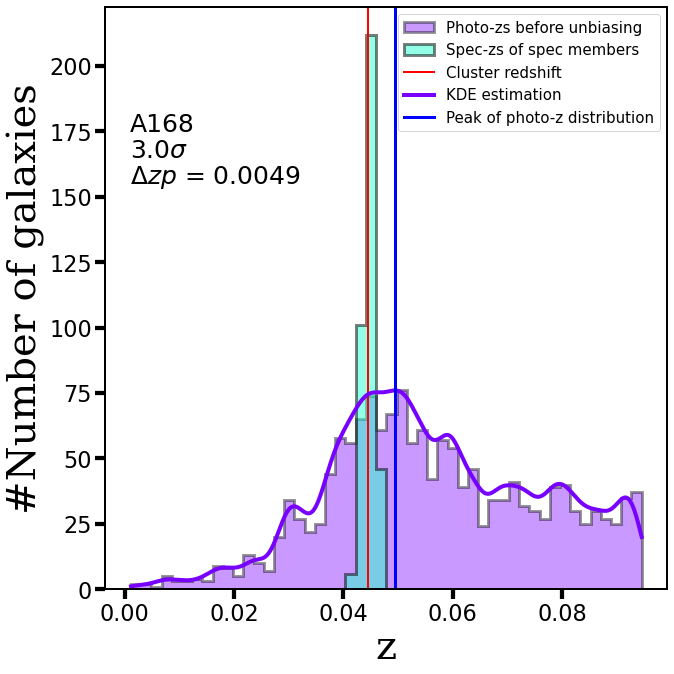

In [63]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

pz_hist = ax1.hist(zml[mask_cluster], bins=50, color=colors3[3], histtype='stepfilled', edgecolor='k', linewidth=3.0,
        range=[zml[mask_cluster].min(), zml[mask_cluster].max()], alpha=0.4, label="Photo-zs before unbiasing")[0]

ax1.hist(z_specz_members, bins=50, color=colors1[3], histtype='stepfilled', edgecolor='k', alpha=0.5, linewidth=3.0,
        range=[zml[mask_cluster].min(), zml[mask_cluster].max()], label="Spec-zs of spec members")

ax1.axvline(z_cluster, color="red", lw=2, label="Cluster redshift")

f = pz_hist[np.argmax(pz_hist)] / np.exp(log_dens_zz_phot)[np.argmax(np.exp(log_dens_zz_phot))]
ax1.plot(zz_phot, np.exp(log_dens_zz_phot)*f, lw=4, color=colors3[3], label="KDE estimation")
ax1.axvline(zz_phot[np.argmax(np.exp(log_dens_zz_phot))], color="blue", lw=3, label="Peak of photo-z distribution")

ax1.text(0.001, 175, s="{}".format(cl_names[cluster]), fontsize=25)
ax1.text(0.001, 165, s=r"{}$\sigma$".format(fz1), fontsize=25)
ax1.text(0.001, 155, s=r"$\Delta zp$ = {:.4f}".format(zp_bias[0]), fontsize=25)


ax1.set_xlabel('z',fontdict=font)
ax1.set_ylabel('#Number of galaxies',fontdict=font)
ax1.legend(fontsize=labelsize)

fig.tight_layout(pad=3.0)

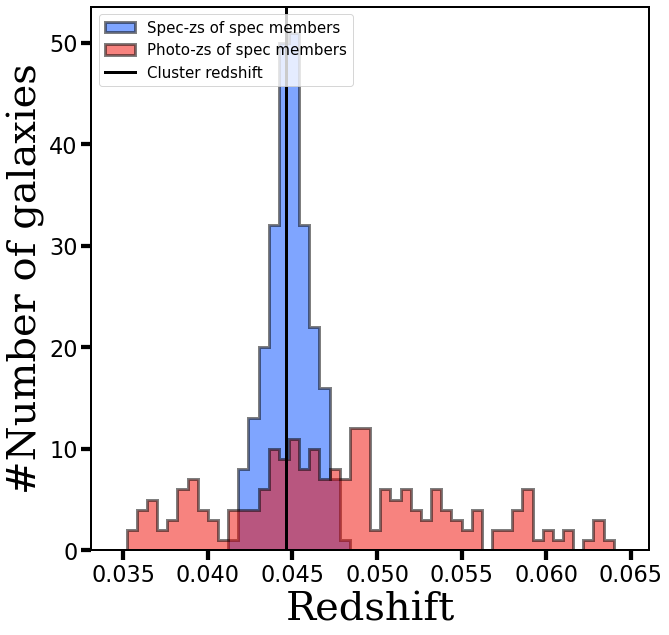

In [64]:
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(111)

ax2.hist(z_specz_members[dist_specz_members < 5*radius_cluster], bins=z_bins, color=colors1[1], histtype='stepfilled', alpha=0.5, 
         range=[z_cluster-0.01, z_cluster+0.02], edgecolor='k', linewidth=3.0, label="Spec-zs of spec members")
ax2.hist(zml_specz_members[dist_specz_members < 5*radius_cluster], bins=z_bins, color=colors1[8], histtype='stepfilled', alpha=0.5, 
         range=[z_cluster-0.01, z_cluster+0.02], edgecolor='k', linewidth=3.0, label="Photo-zs of spec members")

ax2.set_xlabel('Redshift',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(z_cluster, color="black", lw=3, label="Cluster redshift")
ax2.legend(fontsize=15, loc=2)

In [65]:
# Photo-z bias from Paulo
# zp_bias = 0.0048
zp_bias = 0.0021

zml_unbiased = zml - zp_bias

mask_cluster_unbiased = mask_cluster_region & (zml_unbiased > z_cluster - 
                    fz1*sigma_z*(1+z_cluster)) & (zml_unbiased < z_cluster + fz1*sigma_z*(1+z_cluster))

print("zp_bias = {}".format(zp_bias))

zp_bias = 0.0021


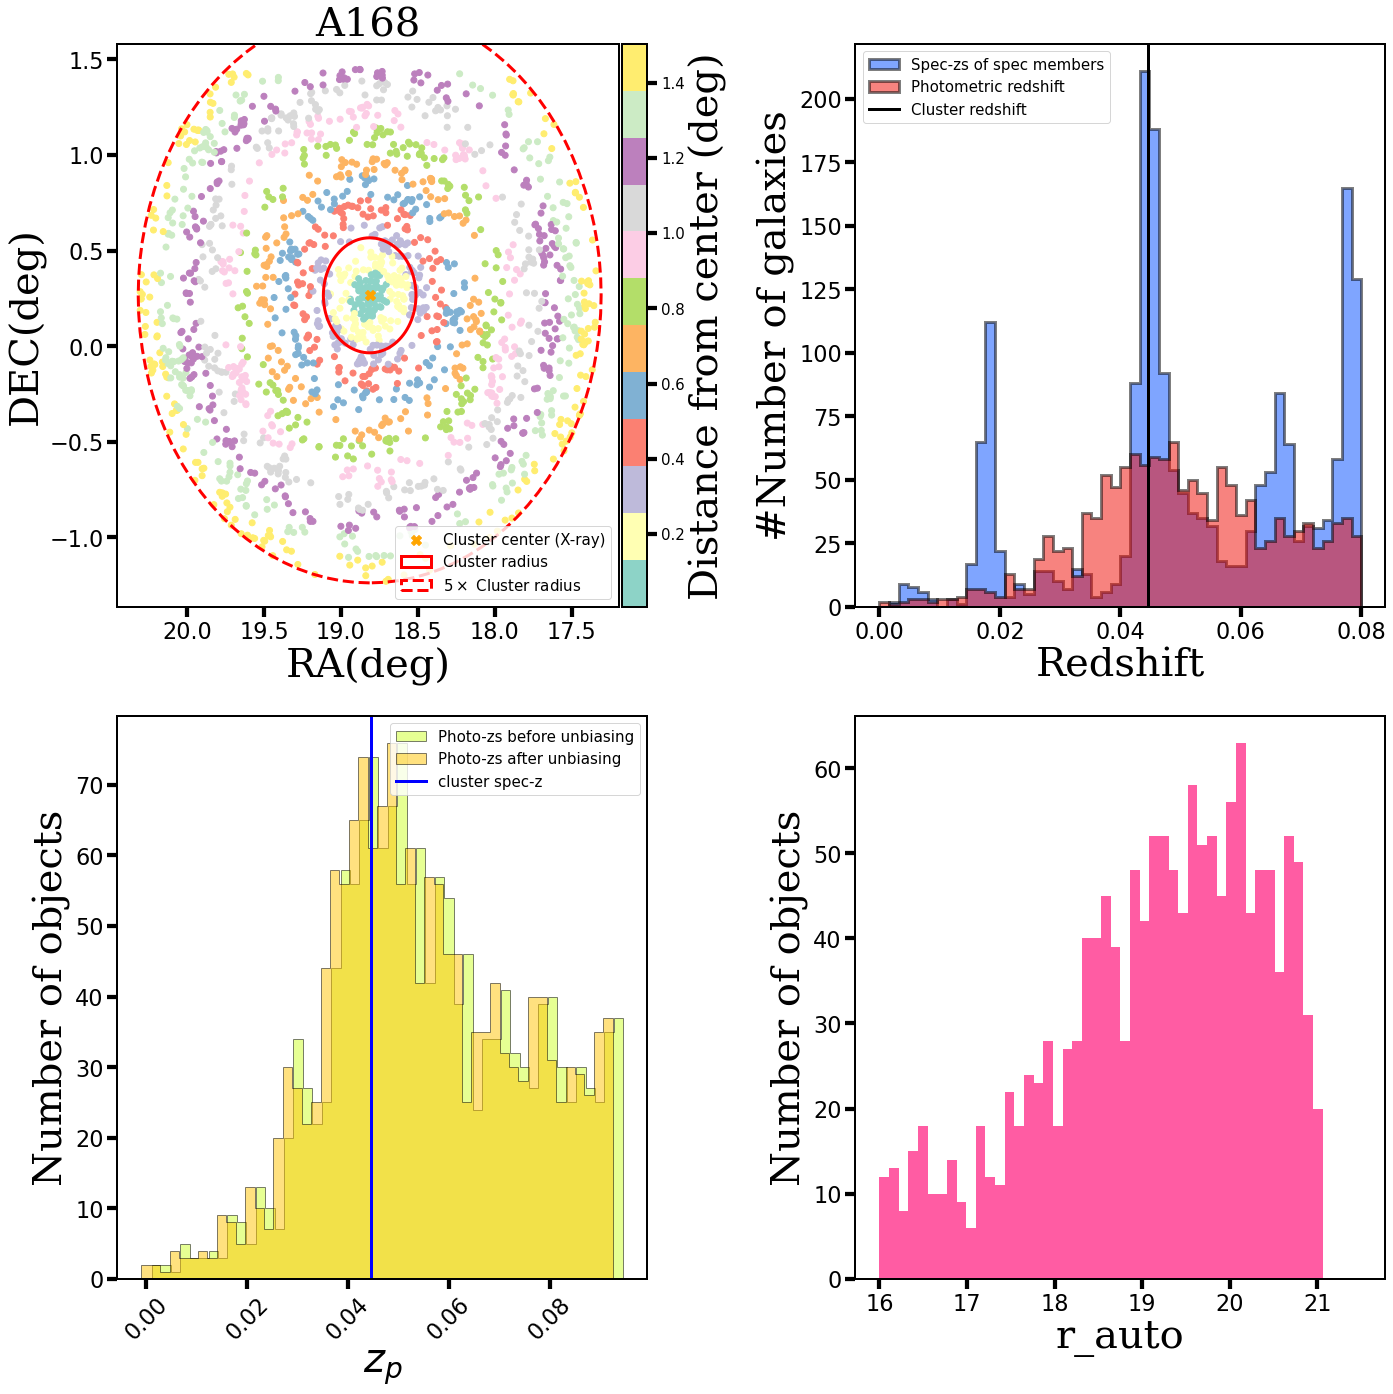

In [66]:
bins = 50
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(221)
sc1 = ax1.scatter(ra[mask_cluster_region], dec[mask_cluster_region], 
            marker='o', c=dist[mask_cluster_region], cmap=cm.Set3, rasterized=True)
ax1.scatter(ra0, dec0, marker="X", s=100, color="orange", label="Cluster center (X-ray)")
# ax1.scatter(ra0_optical, dec0_optical, marker="X", s=100, color="red", label="Cluster center (Optical)")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)
ax1.legend(fontsize=15)


ax2 = fig.add_subplot(222)
ax2.hist(z, bins=z_bins, color=colors1[1], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, edgecolor='k', linewidth=3.0, label="Spec-zs of spec members")
ax2.hist(zml_unbiased[mask_cluster_unbiased], bins=z_bins, color=colors1[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, edgecolor='k', linewidth=3.0, label="Photometric redshift")
ax2.set_xlabel('Redshift',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(z_cluster, color="black", lw=3, label="Cluster redshift")
ax2.legend(fontsize=15, loc=2)


ax3 = fig.add_subplot(223)
ax3.hist(zml[mask_cluster], bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k', 
         range=[zml[mask_cluster].min(), zml[mask_cluster].max()], alpha=0.5, label="Photo-zs before unbiasing")[2]
ax3.hist(zml_unbiased[mask_cluster_unbiased], bins=z_bins, color=colors1[6], histtype='stepfilled', edgecolor='k', 
         range=[zml_unbiased[mask_cluster_unbiased].min(), zml_unbiased[mask_cluster_unbiased].max()], label="Photo-zs after unbiasing", alpha=0.5)[2]
ax3.axvline(z_cluster, color="blue", lw=3, label="cluster spec-z")

# ax3.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax3.set_xlabel(r"$z_p$", fontdict=font)
ax3.set_ylabel("Number of objects", fontdict=font)
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=labelsize)


ax4 = fig.add_subplot(224)
ax4.hist(rauto[mask_cluster], alpha=1.0, bins=bins, histtype='stepfilled', color=colors3[5], range=(16, 21.5))
# ax4.set_title(cl_names[cluster], fontdict=font)
ax4.set_xlabel("r_auto", fontdict=font)
ax4.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-real-clusters/photoz_rPStotal_distributions_{}.png".format(cl_names[cluster]), dpi='figure', format='png')


## George+11 method 
### Compute priors using spectroscopic members and non-members as estimates of the number of field and cluster galaxies

$$P( g \in C) = \frac{\text{Number of spectroscopic members in the volume of the cluster}}{\text{Total number of galaxies in the volume of the cluster}}$$

In [40]:
z_members, id_members = sigma_clipping(z[mask_redshift_specz][mask_cluster_specz], objid_specz[mask_redshift_specz][mask_cluster_specz], z_lower, z_upper, 3.0)
mask_members = np.isin(objid_specz[mask_redshift_specz][mask_cluster_specz], id_members)

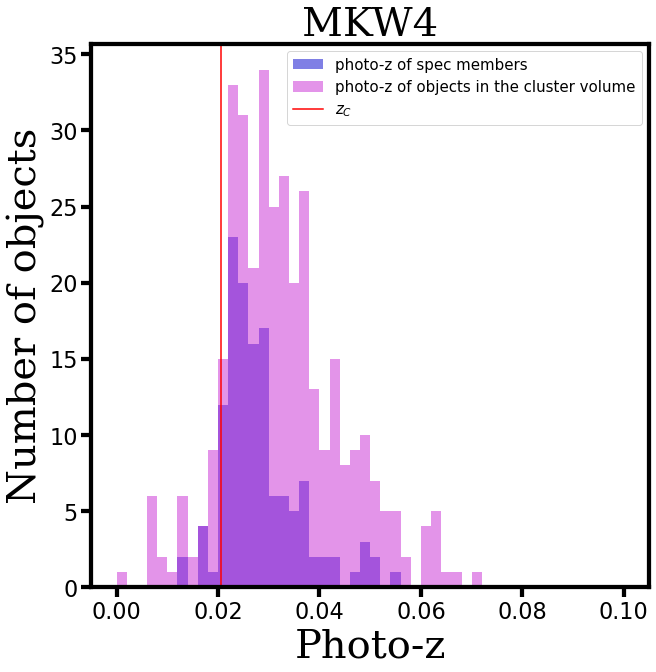

In [41]:
bins = 50
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.hist(zml_specz[mask_redshift_specz][mask_cluster_specz][mask_members], bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=0.5, label="photo-z of spec members", range=(0, 0.1))
ax1.hist(zml_specz[mask_redshift_specz][mask_cluster_specz], bins=bins, histtype='stepfilled', 
         color=colors3[4], alpha=0.5, label="photo-z of objects in the cluster volume", range=(0, 0.1))
ax1.set_title(cl_names[cluster], fontdict=font)
ax1.set_xlabel("Photo-z", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.axvline(z_cluster, color="red", label=r"$z_C$")
ax1.legend(fontsize=15)

In [42]:
P_ginG = np.sum(mask_members) / np.sum(mask_cluster_specz)
P_ginF = 1 - P_ginG

print("P (g in C) = {:.3f}".format(P_ginG))
print("P (g in F) = {:.3f}".format(P_ginF))

P (g in C) = 0.369
P (g in F) = 0.631


### Compute membership probabilities for spectroscopic members to estimate purity and completeness

In [43]:
P_pz_G_i_array, P_pz_F_i_array = zp_mem_prob(zml_specz[mask_redshift_specz][mask_cluster_specz], z_cluster, 
                                             pdf_means_specz.T[mask_redshift_specz][mask_cluster_specz], 
                                             pdf_weights_specz.T[mask_redshift_specz][mask_cluster_specz],
                                             pdf_stds_specz.T[mask_redshift_specz][mask_cluster_specz], sigma_specz)

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:243: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:248: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrange

In [44]:
Pmem_pz_C = (P_pz_G_i_array * P_ginG) / (P_pz_G_i_array * P_ginG + P_pz_F_i_array * P_ginF)

In [45]:
completeness = []
purity = []
d = 0.01
crit = np.arange(0.0, 1.0, d)

for c in crit:
    completeness.append(np.sum((Pmem_pz_C > c) & mask_members) / np.sum(mask_members))
    purity.append(np.sum(mask_members & (Pmem_pz_C > c)) / np.sum((Pmem_pz_C > c)))

/tmp/ipykernel_6438/3004653241.py:8: RuntimeWarning: invalid value encountered in long_scalars
  purity.append(np.sum(mask_members & (Pmem_pz_C > c)) / np.sum((Pmem_pz_C > c)))


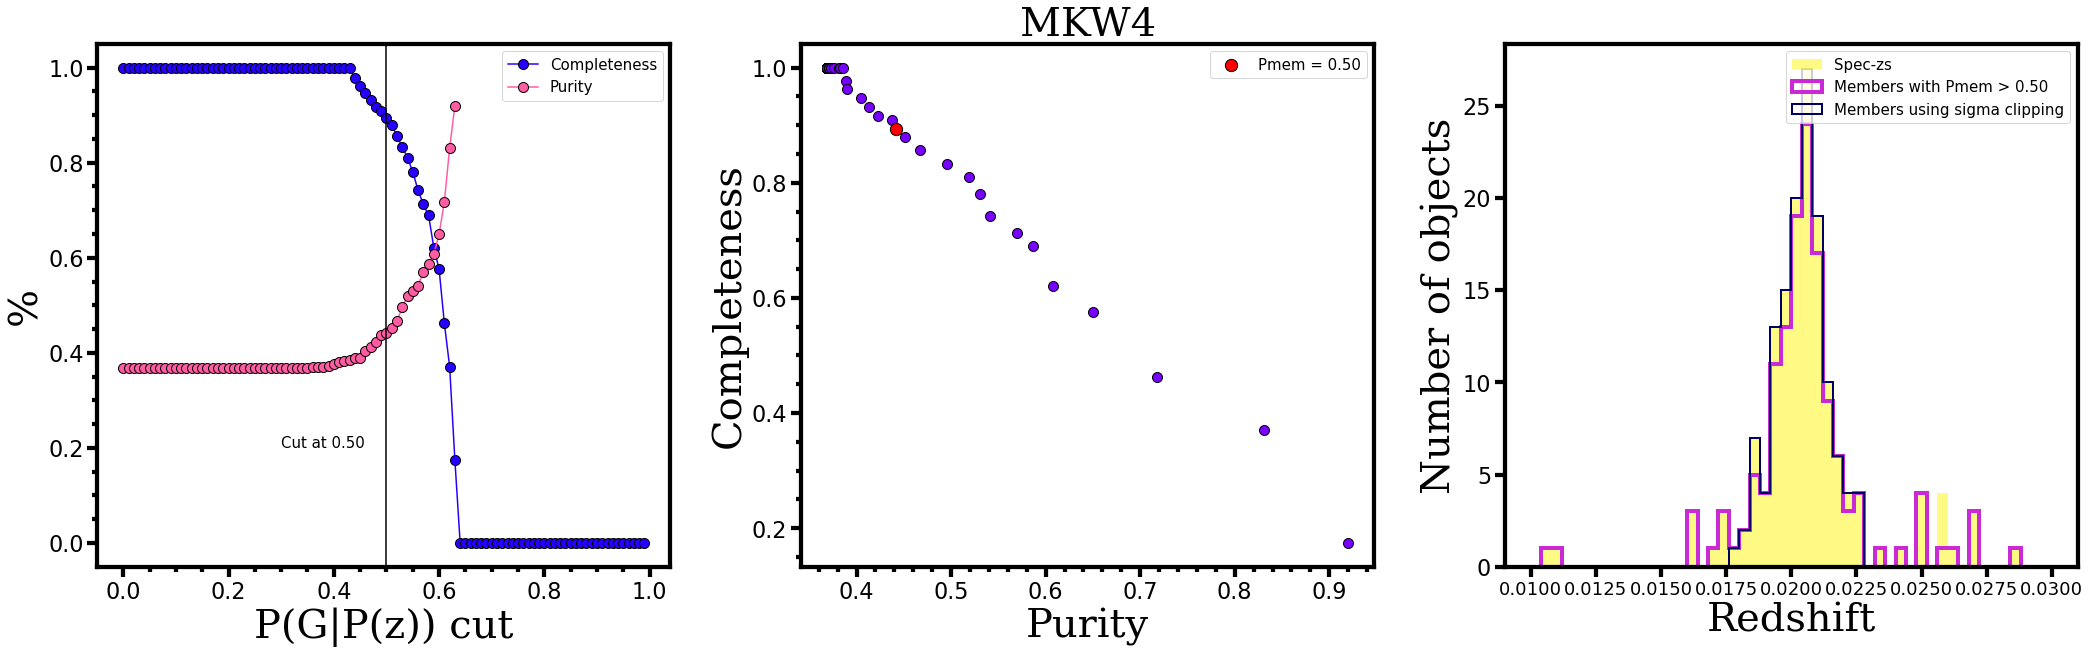

In [46]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(131)
ms = 10
ax1.plot(crit, completeness, marker='o', color=colors3[2], 
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(crit, purity, marker='o', color=colors3[5], 
         label="Purity", markersize=ms, markeredgecolor="black")

ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(G|P(z)) cut", fontdict=font)
ax1.minorticks_on()

lg=plt.legend(fontsize=15)
lg.draw_frame(True)

cut = 0.50
ax1.axvline(cut, color="black")
ax1.text(x=cut-0.2, y=0.2, s="Cut at {:.2f}".format(cut), fontsize=15)
# ax1.text(x=0.03, y=0.8, s="P(g in F) = {:.2f}".format(P_ginF), fontsize=15)
# ax1.text(x=0.03, y=0.75, s="P(g in C) = {:.2f}".format(P_ginG), fontsize=15)

ax2 = fig.add_subplot(132)
ax2.scatter(purity, completeness, marker='o', color=colors3[3], s=100, edgecolor="black")

ax2.scatter(purity[np.argwhere(np.abs(crit - cut) == np.abs(crit - cut).min())[0][0]], completeness[np.argwhere(np.abs(crit - cut) == np.abs(crit - cut).min())[0][0]],
            marker='o', color="red", s=150, edgecolor="black", label="Pmem = {:.2f}".format(cut))

ax2.set_ylabel("Completeness", fontdict=font)
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_title(cl_names[cluster], fontdict=font)
ax2.minorticks_on()

lg=plt.legend(fontsize=15)
lg.draw_frame(True)



ax3 = fig.add_subplot(133)
bins = 50
ax3.hist(z[mask_redshift_specz][mask_cluster_specz], alpha=0.5, label='Spec-zs', bins=bins, range=(z_lower, z_upper), 
        histtype='stepfilled', color=colors3[8])
ax3.hist(z[mask_redshift_specz][mask_cluster_specz][Pmem_pz_C > cut], alpha=1.0, label='Members with Pmem > {:.2f}'.format(cut), 
        bins=bins, range=(z_lower, z_upper), histtype='step', lw=4, color=colors3[4])
ax3.hist(z_members, alpha=1.0, label='Members using sigma clipping'.format(cut), bins=bins, range=(z_lower, z_upper), 
        histtype='step', lw=2, color=colors3[0])

ax3.set_xlabel("Redshift", fontdict=font)
ax3.set_ylabel("Number of objects", fontdict=font)

ax3.tick_params(axis='x', labelsize=18)

lg=plt.legend(fontsize=15)
lg.draw_frame(True)

fig.tight_layout(pad=4.0)

# plt.savefig("../figures/clusters-membership/purity_completeness_5R200_spec-priors_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

## Laerte's method 

- Definimos a probabilidade $P(C | z_p)$ integrando a PDF do photo-z da galáxia, $\mathcal{P(z_p)}$, em um intervalo $z_c - \alpha  \sigma_{NMAD} < z_p \leq z_c + \alpha  \sigma_{NMAD}$, onde em geral estamos usando $\alpha = 3$. Ou seja:

$$
P(C | z_p) = \int_{z_c - \alpha  \sigma_{NMAD}}^{z_c + \alpha  \sigma_{NMAD}} \mathcal{P(z_p)} d z_p
$$

- Vamos definir as galáxias candidatas à membro como aquelas satisfazendo $P(C | z_p) > p_0$, onde o corte $p_0$ pode ser definido otimizando-se o F1 score:

$$
F1 = 2 \times \frac{\text{completeness} \times \text{purity}}{\text{completeness} + \text{purity}}
$$

- Em seguida, a ideia é que as galáxias satisfazendo esse critério sejam utilizadas para calcular o P(C | R)

In [67]:
P_pz_C_array = P_pz_v2(z_cluster, rauto[mask_cluster_unbiased],pdf_means.T[mask_cluster_unbiased], 
                       pdf_weights.T[mask_cluster_unbiased], pdf_stds.T[mask_cluster_unbiased], fz=3.0)

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:329: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:336: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

### Purity and completeness

In [18]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for c in Pmem_cut_arr_zp:
    completeness_zp.append(np.sum(np.isin(objid_specz, objid[mask_redshift][mask_cluster_region][P_pz_C_array > c]))
                        / len(objid_specz))
    purity_zp.append(np.sum(np.isin(objid[mask_redshift][mask_cluster_region][P_pz_C_array > c], objid_specz)) 
                        / len(objid[mask_redshift][mask_cluster_region][P_pz_C_array > c]))

In [19]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_zp = np.array(completeness_zp)
purity_zp = np.array(purity_zp)

F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

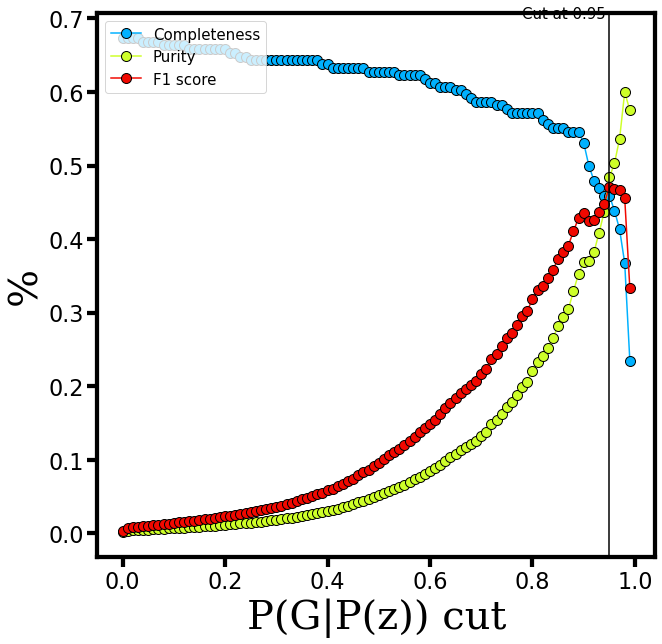

In [20]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, F1_zp, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")


ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(G|P(z)) cut", fontdict=font)

ax1.axvline(cut_zp, color="black")
ax1.text(x=cut_zp-0.17, y=0.7, s="Cut at {:.2f}".format(cut_zp), fontsize=15)

# c_best = 0.65
# ax1.axhline(c_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

# p_best = 0.41
# ax1.axhline(p_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

ax1.legend(fontsize=labelsize, loc=2)

### Plots

In [68]:
cut_zp = 0.89

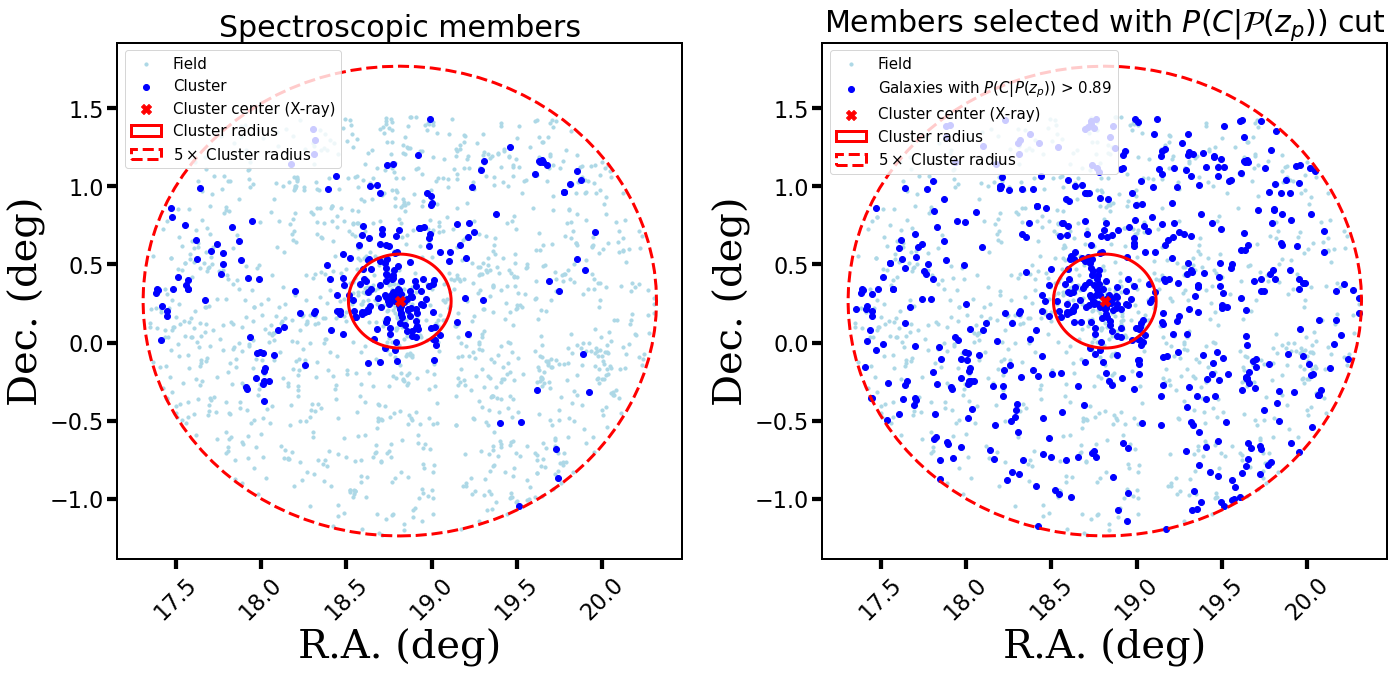

In [69]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
# ax1.scatter(ra_specz[dist_specz < fr*radius_cluster], dec_specz[dist_specz < fr*radius_cluster], c="blue", label="Cluster")
ax1.scatter(ra_specz_members[dist_specz_members < fr*radius_cluster], dec_specz_members[dist_specz_members < fr*radius_cluster], c="blue", label="Cluster")
ax1.set_title("Spectroscopic members", fontsize=30)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center (X-ray)")
# ax1.scatter(ra0_optical, dec0_optical, marker="X", s=100, color="orange", label="Cluster center (Optical)")
ax1.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)
ax1.legend(fontsize=labelsize)


ax2.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster_unbiased][P_pz_C_array > cut_zp], 
            dec[mask_cluster_unbiased][P_pz_C_array > cut_zp], c="blue", 
            label=r"Galaxies with $P(C | P(z_p))$ > {:.2f}".format(cut_zp))
ax2.set_title(r"Members selected with $P(C|\mathcal{P}(z_p))$ cut", fontsize=30)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center (X-ray)")
# ax2.scatter(ra0_optical, dec0_optical, marker="X", s=100, color="orange", label="Cluster center (Optical)")
ax2.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r1)
ax2.add_patch(r5)
ax2.legend(fontsize=labelsize)

    
fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-real-clusters/specz_phot_members_distributions_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

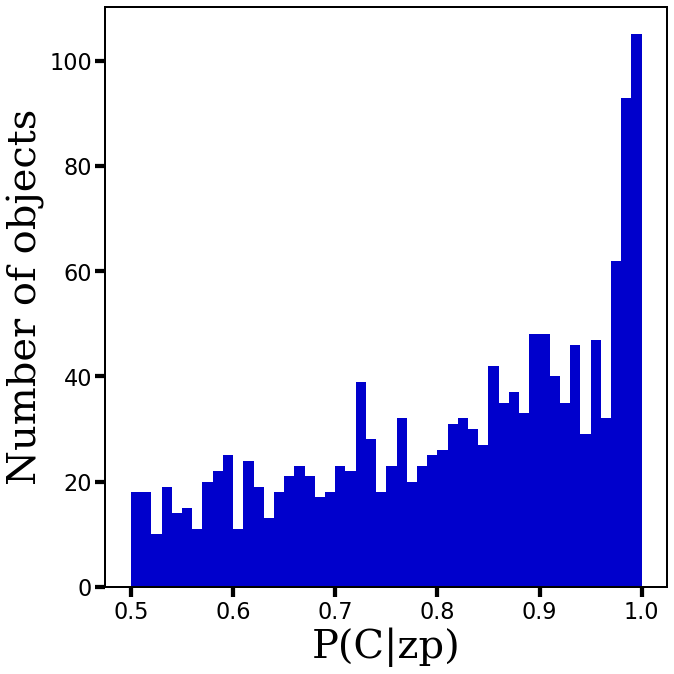

In [70]:
bins = 50
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(P_pz_C_array, bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0, range=[0.5, 1.0])
ax1.set_xlabel("P(C|zp)", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-real-clusters/P(C | P(zp))_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

## Compute "radial" membership probabilities

 - Ideia: queremos associar uma probabilidade de membership "radial" às galáxias na região do aglomerado;
 - Teremos uma probabilidade de pertencimento ao aglomerado ($P(C|R)$) e uma probabilidade de pertencimento ao campo ($P(F|R)$), onde C = cluster, F = field, R = distância projetada entre galáxia e centro do aglomerado;
 - Vamos assumir para o aglomerado (C) e campo (F) os seguintes perfis cumulativos radiais:
 
 $$
 \begin{align}
     &\Sigma_C = w_1 R^{-\alpha}\\
     &\Sigma_F = w_2
 \end{align}
 $$
 
 De tal forma que $P(C|R) \propto \Sigma_C$ e $P(F|R) \propto \Sigma_F$.
 
 - Podemos demonstrar que 
 
 $$
 w_2 = \frac{N_T - N_C(R_{max})}{\pi R^2_{max}}
 $$
 
 De forma que vão restar apenas dois parâmetros independentes ($w_1$ e $\alpha$ por exemplo)
 
- Na prática a ideia é ajustar esses dois perfis conjuntamente à distribuição cumulativa radial das galáxias no aglomerado;
- Ou seja, vou ter que pegar as distâncias das galáxias e criar a distribuição radial cumulativa delas, indo $r_c = 0$ até $r_c = 5R_{200}$ por exemplo
- O que a gente vai fitar são os perfis cumulativos, ou seja, $\Sigma_C$ e $\Sigma_F$ integradas em coordenadas polares:
  
 $$
 \begin{align}
     &\rho_C = 2 \pi \int_0^R \Sigma_C R dR = 2 \pi w_1 \frac{R^{2 - \alpha}}{2 - \alpha}\\
     &\rho_F = 2 \pi \int_0^R \Sigma_F R dR = \pi w_2 R^2 
 \end{align}
 $$
 
- As probabilidades finais serão:

$$
P(C | R) = \frac{\rho_C(R)}{\rho_C(R) + \rho_F(R)}
$$

In [71]:
#To go to the radial probabilities, we have to define a cut in P(C | zp), computed above
mask_cluster_zp = (P_pz_C_array > cut_zp)

def radial_fit():
    no_radial_fit = False
    frr = 5
    while frr > 0:
        try:
            mask_cluster_R = (dist[mask_cluster_unbiased] < frr*radius_cluster) & mask_cluster_zp
            Pmem_R_C, Pmem_R_F, w1, w2, alpha = radial_mem_prob(dist[mask_cluster_unbiased][mask_cluster_R], rc=radius_cluster, name="Abell 168", fz=fz1, cluster_profile="power-law", plot=True)
            return Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit
        except RuntimeError:
            frr -= 0.5
            if frr == 0:
                print(f"Fit attempt with frr={frr} failed. It seems this cluster cannot be fitted with the given profile.")
                no_radial_fit = True

                Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R = [np.nan] * 6
                return Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit

            else:
                pass

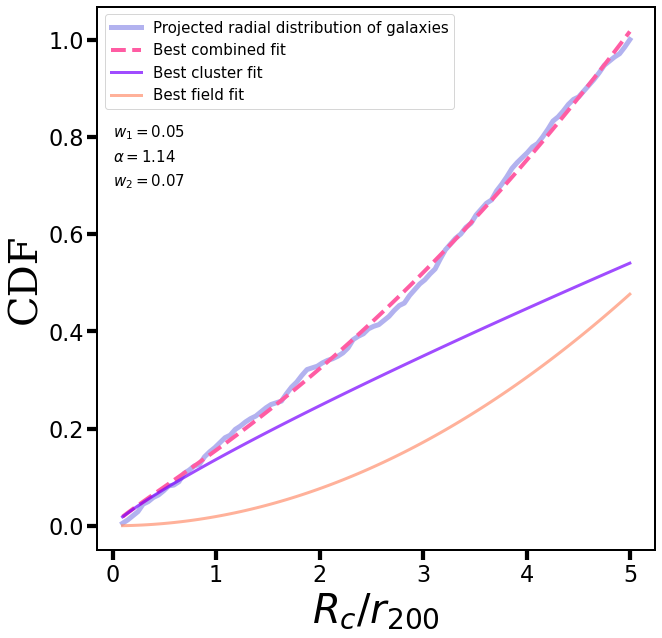

In [72]:
Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit = radial_fit()

### Purity and completeness

In [57]:
completeness_R = []
purity_R = []
d = 0.01
Pmem_cut_arr_R = np.arange(0.0, 1.0, d)

for c in Pmem_cut_arr_R:
    completeness_R.append(np.sum(np.isin(objid_specz, objid[mask_redshift][mask_cluster_region][mask_cluster][Pmem_R_C > c]))
                        / len(objid_specz))
    purity_R.append(np.sum(np.isin(objid[mask_redshift][mask_cluster_region][mask_cluster][Pmem_R_C > c], objid_specz)) 
                        / len(objid[mask_redshift][mask_cluster_region][mask_cluster][Pmem_R_C > c]))

In [61]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_R = np.array(completeness_R)
purity_R = np.array(purity_R)

F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)

cut_R = Pmem_cut_arr_R[np.argmax(F1_R[~np.isnan(F1_R)])]

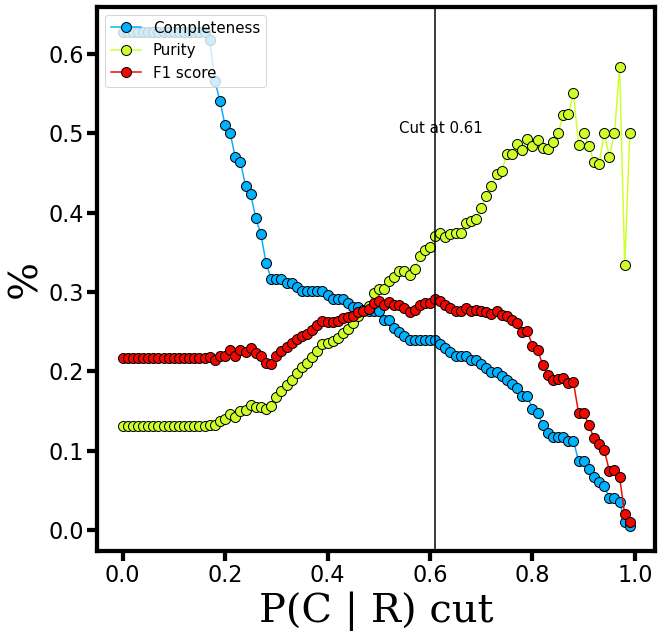

In [65]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_R, completeness_R, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, purity_R, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, F1_R, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")


ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C | R) cut", fontdict=font)

ax1.axvline(cut_R, color="black")
ax1.text(x=cut_R-0.07, y=0.5, s="Cut at {:.2f}".format(cut_R), fontsize=15)


ax1.legend(fontsize=labelsize, loc=2)

### Plots

In [73]:
cut_R = 0.85

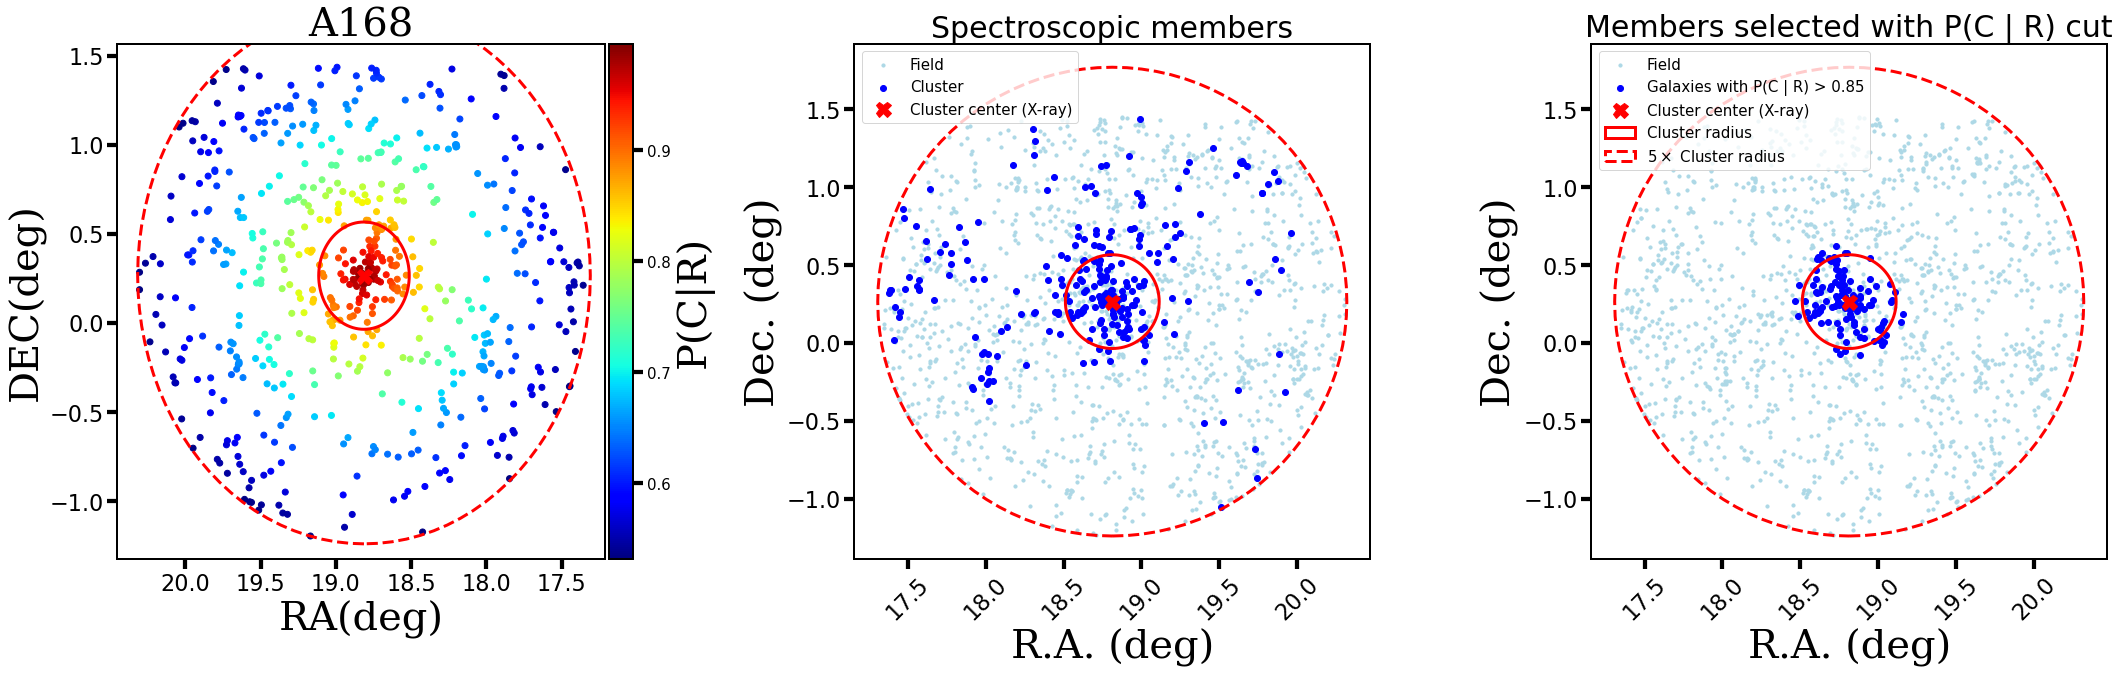

In [74]:
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sc1 = ax1.scatter(ra[mask_cluster_unbiased][mask_cluster_R], 
                  dec[mask_cluster_unbiased][mask_cluster_R], 
                  marker='o', c=Pmem_R_C, cmap="jet", rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="P(C|R)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)


ax2.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra_specz_members[dist_specz_members < fr*radius_cluster], dec_specz_members[dist_specz_members < fr*radius_cluster], c="blue", label="Cluster")
ax2.set_title("Spectroscopic members", fontsize=30)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax2.legend(fontsize=labelsize)
ax2.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r1)
ax2.add_patch(r5)


ax3.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
ax3.scatter(ra[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], 
            dec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], c="blue", 
            label="Galaxies with P(C | R) > {:.2f}".format(cut_R))
ax3.set_title("Members selected with P(C | R) cut", fontsize=30)
ax3.set_xlabel("R.A. (deg)", fontdict=font)
ax3.set_ylabel("Dec. (deg)", fontdict=font)
ax3.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax3.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax3.add_patch(r1)
ax3.add_patch(r5)
ax3.legend(fontsize=labelsize)
    
fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-real-clusters/P(C|R)_spec_phot_members_distributions_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

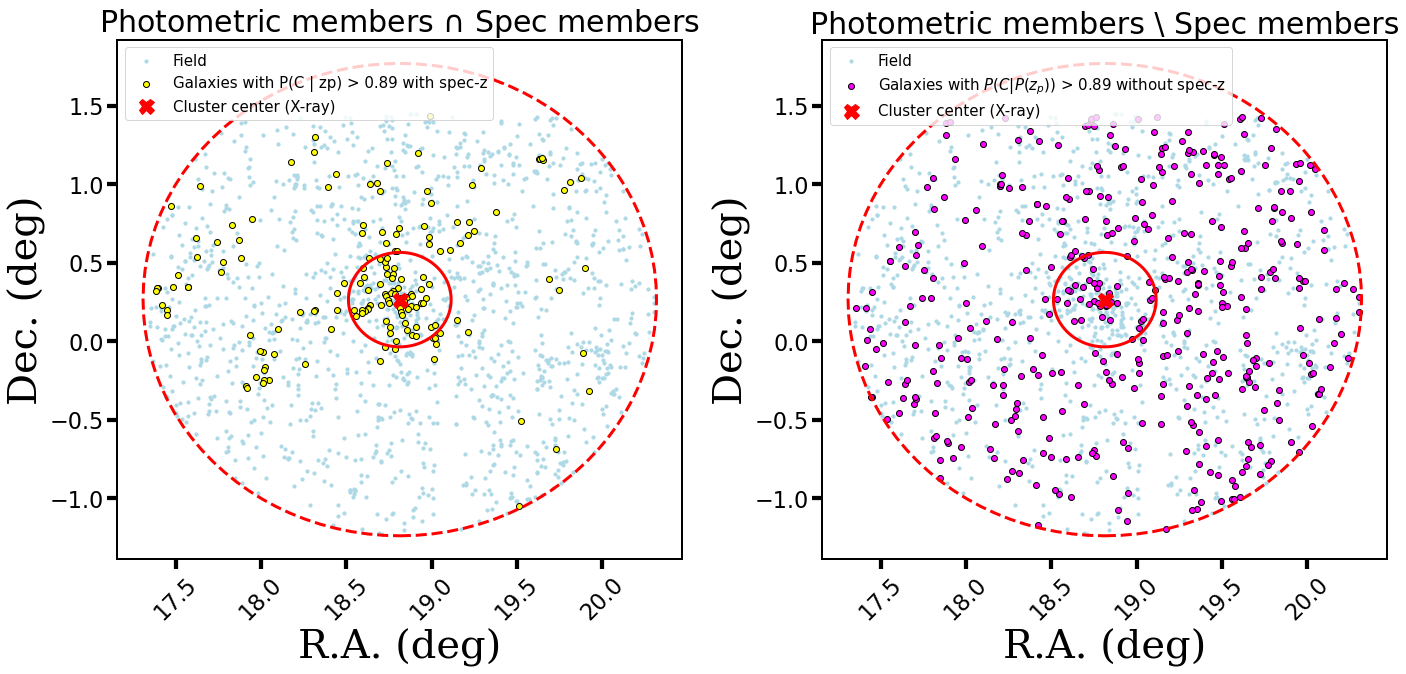

In [75]:
rcParams["axes.linewidth"] = 2.0

fig = plt.figure(figsize=(20, 10))
# ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)

# ax1.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], c="lightblue", s=10, label="Field")
# ax1.scatter(ra_specz_members[dist_specz_members < fr*radius_cluster], dec_specz_members[dist_specz_members < fr*radius_cluster], c="blue", label="Cluster")
# ax1.set_title("Spectroscopic members", fontsize=30)
# ax1.set_xlabel("R.A. (deg)", fontdict=font)
# ax1.set_ylabel("Dec. (deg)", fontdict=font)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
# ax1.tick_params(axis='x', rotation=45)

# r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
#             lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
# r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
#             lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
# ax1.add_patch(r1)
# ax1.add_patch(r5)
# ax1.legend(fontsize=labelsize)


mask_phot_with_spec = flag_member[mask_cluster_unbiased][mask_cluster_zp] == 0
ax2.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_zp][mask_phot_with_spec], dec[mask_cluster_unbiased][mask_cluster_zp][mask_phot_with_spec], color="yellow", 
                label="Galaxies with P(C | zp) > {:.2f} with spec-z".format(cut_zp), edgecolor="k")
# ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_zp][~mask_phot_with_spec], dec[mask_cluster_unbiased][mask_cluster_zp][~mask_phot_with_spec], color="fuchsia", 
#                 label="Galaxies with P(C | zp) > {:.2f} without spec-z".format(cut_zp), edgecolor="k")
ax2.set_title(r"Photometric members $\cap$ Spec members", fontsize=30)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=15)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r1)
ax2.add_patch(r5)


# mask_phot_with_spec = flag_member[mask_cluster_unbiased][mask_cluster_zp] == 0
ax3.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
# ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_zp][mask_phot_with_spec], dec[mask_cluster_unbiased][mask_cluster_zp][mask_phot_with_spec], color="yellow", 
#                 label="Galaxies with P(C | zp) > {:.2f} with spec-z".format(cut_zp), edgecolor="k")
ax3.scatter(ra[mask_cluster_unbiased][mask_cluster_zp][~mask_phot_with_spec], dec[mask_cluster_unbiased][mask_cluster_zp][~mask_phot_with_spec], color="fuchsia", 
                label=r"Galaxies with $P(C | P(z_p))$ > {:.2f} without spec-z".format(cut_zp), edgecolor="k")
ax3.set_title(r"Photometric members \ Spec members", fontsize=30)
ax3.set_xlabel("R.A. (deg)", fontdict=font)
ax3.set_ylabel("Dec. (deg)", fontdict=font)
ax3.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=15)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax3.add_patch(r1)
ax3.add_patch(r5)

    
fig.tight_layout(pad=3.0)

plt.savefig("../figures/membership-paper-a168-mkw4/phot_members_with_and_without_specz_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

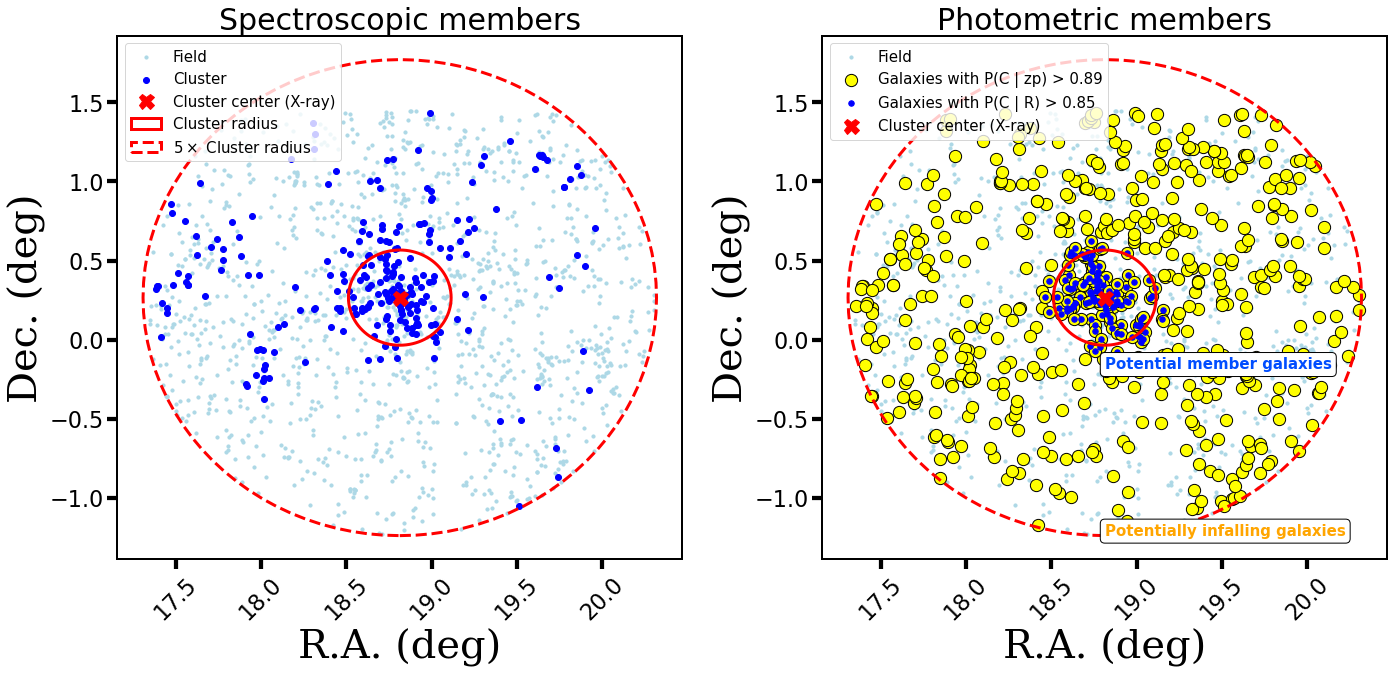

In [76]:
# mask_phot_with_spec = np.isin(objid[mask_cluster_unbiased][mask_cluster_zp], objid_specz)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], c="lightblue", s=10, label="Field")
ax1.scatter(ra_specz_members[dist_specz_members < fr*radius_cluster], dec_specz_members[dist_specz_members < fr*radius_cluster], c="blue", label="Cluster")
ax1.set_title("Spectroscopic members", fontsize=30)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax1.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)
ax1.legend(fontsize=15)



ax2.scatter(ra[mask_cluster_unbiased], dec[mask_cluster_unbiased], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_zp], dec[mask_cluster_unbiased][mask_cluster_zp], color="yellow", 
                label="Galaxies with P(C | zp) > {:.2f}".format(cut_zp), edgecolor="k", s=150)
ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], dec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], c="blue", 
            label="Galaxies with P(C | R) > {:.2f}".format(cut_R), s=30)
ax2.set_title("Photometric members and infalling galaxies", fontsize=30)
ax2.set_title("Photometric members", fontsize=30)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center (X-ray)")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=15, loc=2)

ax2.text(ra0, dec0-5*radius_cluster, s="Potentially infalling galaxies", fontsize=15, color="orange", bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")
ax2.text(ra0, dec0-1.5*radius_cluster, s="Potential member galaxies", fontsize=15, color=colors1[1], bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r1)
ax2.add_patch(r5)

    
    
fig.tight_layout(pad=3.0)

plt.savefig("../figures/membership-paper-a168-mkw4/cluster_field_separation_final_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

### Saving results to csv

In [191]:
if cl_names[cluster] == "A168":
    t = pd.read_csv("tables/a168/a168_cleaned.csv")
    
if cl_names[cluster] == "MKW4":
    t = pd.read_csv("tables/mkw4/mkw4_cleaned.csv")
    
rauto = np.asarray(t["r_auto"])
t = t[~np.isnan(rauto)]

t_members = t[mask_cluster_unbiased]

t_members.loc[:, "Pmem_zp"] = P_pz_C_array
t_members.loc[:, "R"] = dist[mask_cluster_unbiased] / radius_cluster

t_members.loc[np.array(t_members["Pmem_zp"]) > cut_zp, "Pmem_R"] = Pmem_R_C
t_members.loc[np.array(t_members["Pmem_zp"]) < cut_zp, "Pmem_R"] = 0

t_members.to_csv("tables/membership_tables/{}_members.csv".format(cl_names[cluster]), index=False)


#This table is obtained by crosmatching (on TOPCAT) the members table above with the "_selected.csv" table provided by Claudia (I don't even know how the "_selected.csv" was created)
#1 arcsec crossmatch all from 1 (all from _selected)
t_final = pd.read_csv("tables/membership_tables/{}_members_selected_crossmatch.csv".format(cl_names[cluster]))

t_final.loc[np.array(t_final["Pmem_zp"]) > cut_zp, "photz1"] = 0 #members
t_final.loc[np.array(t_final["Pmem_zp"]) < cut_zp, "photz1"] = 1 #interlopers
t_final.loc[np.isnan(np.array(t_final["Pmem_zp"])), "photz1"] = -1 #undetermined

#Essa aqui é basicamente a tabela no formato final que a Claudia pediu, com essa coluna #photz1
t_final.to_csv("tables/membership_tables/{}/members/{}_final.csv".format(cl_names[cluster], cl_names[cluster]), index=False)

/tmp/ipykernel_1033800/274834340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_members.loc[:, "Pmem_zp"] = P_pz_C_array
/tmp/ipykernel_1033800/274834340.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_members.loc[:, "R"] = dist[mask_cluster_unbiased] / radius_cluster
/tmp/ipykernel_1033800/274834340.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [77]:
#Trying to do the same thing with the new table
if cl_names[cluster] == "A168":
#     t = pd.read_csv("tables/a168/a168_cleaned.csv")
    t = pd.read_csv("tables/A168/A168-05012025.csv")
    
if cl_names[cluster] == "MKW4":
#     t = pd.read_csv("tables/MKW4/mkw4_cleaned.csv")
    t = pd.read_csv("tables/MKW4/MKW4-05012025.csv")
    
rauto = np.asarray(t["r_auto"])
t2 = t[~np.isnan(rauto)]

mask_cluster_unbiased_aux = np.isin(t.index, t2[mask_cluster_unbiased].index)

# t_members = t[mask_cluster_unbiased_aux]

t.loc[mask_cluster_unbiased_aux, "Pmem_zp"] = P_pz_C_array
t.loc[mask_cluster_unbiased_aux, "R"] = dist[mask_cluster_unbiased] / radius_cluster

# t.loc[t["Pmem_zp"] > cut_zp, "Pmem_R"] = Pmem_R_C
# t.loc[t["Pmem_zp"] < cut_zp, "Pmem_R"] = 0

t.loc[t["Pmem_zp"] > cut_zp, "flag_member_photz1"] = 0 #members
t.loc[t["Pmem_zp"] < cut_zp, "flag_member_photz1"] = 1 #interlopers
t.loc[np.isnan(np.array(t["Pmem_zp"])), "flag_member_photz1"] = -1 #undetermined

In [81]:
t.to_csv("tables/{}/members/{}_final-16012025.csv".format(cl_names[cluster], cl_names[cluster]), index=False)

### Computing completeness (relative to the number of spec-z members) 

I am computing the completeness in the following way: <br>
I consider the completeness as the ratio

$$
C = \frac{\text{Phot members} \cap \text{Spec members} }{\text{Spec members inside } 5R_{200}}
$$

We have to consider only spec members inside $5R_{200}$ because we are only considering phot members inside $5R_{200}$ as well, so it wouldn't be fair to compare phot members with spec members beyond $5R_{200}$
- For MKW4: 66%
- For A168: 66%

In [37]:
#Result for the old table ("..._cleaned.csv")
cluster = 1
t_final = pd.read_csv("tables/{}/members/{}_final.csv".format(cl_names[cluster], cl_names[cluster]))

completeness = np.sum((np.array(t_final["flag_member"]) == 0) & (np.array(t_final["photz1"]) == 0)) / np.sum((np.array(t_final["flag_member"]) == 0) & (np.array(t_final["R"]) < 5))
print(completeness)

0.6611570247933884


In [78]:
#Computing the same thing for the members obtained with the "...05012025.csv" tables
completeness = np.sum((np.array(t["flag_member"]) == 0) & (np.array(t["flag_member_photz1"]) == 0)) / np.sum((np.array(t["flag_member"]) == 0) & (np.array(t["R"]) < 5))
print(completeness)

0.6571428571428571


In [79]:
#How many members I loose if I cut in zc - 0.02 <= zp <= zc + 0.02
np.sum((t["flag_member_photz1"] == 0) & (t["zml"] > z_cluster - 0.02) & (t["zml"] < z_cluster + 0.02)) / np.sum((t["flag_member_photz1"] == 0))

0.852991452991453

In [80]:
completeness = np.sum((np.array(t["flag_member"]) == 0) & (np.array(t["flag_member_photz1"]) == 0) & (t["zml"] > z_cluster - 0.02) & 
                      (t["zml"] < z_cluster + 0.02)) / np.sum((np.array(t["flag_member"]) == 0) & (np.array(t["R"]) < 5))
print(completeness)

0.6571428571428571
